# Generator a la SRGAN

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs

In [4]:
# So far unable to get html reprs working with tqdm.notebook. So switch bach to old xr display
xr.set_options(display_style='text')

In [5]:
from src.dataloader import *

In [6]:
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

In [7]:
ds_train = TiggeMRMSDataset(
    tigge_dir='/datadrive_ssd/tigge/32km/',
    tigge_vars=['total_precipitation', '2m_temperature'],
    mrms_dir='/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive_ssd/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018', '2019'),
    val_days=6,
    split='train'
)

Loading data


In [8]:
ds_valid = TiggeMRMSDataset(
    tigge_dir='/datadrive_ssd/tigge/32km/',
    tigge_vars=['total_precipitation', '2m_temperature'],
    mrms_dir='/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive_ssd/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018', '2018'),
    first_days=2,
    val_days=1,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

Loading data


In [9]:
len(ds_train), len(ds_valid)

(41184, 828)

In [10]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [11]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [12]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([32, 2, 16, 16]), torch.Size([32, 1, 128, 128]))

In [15]:
np.isnan(ds_train.tigge.values).sum()

0

In [18]:
np.isnan(ds_train.mrms.values).sum()

0

In [16]:
ds_train.tigge.min()

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00

In [17]:
ds_train.tigge.max()

<xarray.DataArray ()>
array(1., dtype=float32)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00

In [13]:
np.isnan(X.numpy()).sum()

0

In [19]:
import torch.nn as nn
import torch

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

## Generator

In [21]:
from src.trainer import *
from src.models import *

In [22]:
model = Generator(
    nres=3,
    nf_in=ds_train.input_vars,
    nf=64,
    relu_out=False
).to(device)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
trainer = Trainer(
    model,
    optimizer,
    criterion,
    dl_train,
    dl_valid,
    early_stopping_patience=2
)

In [25]:
trainer.fit(epochs=5)


Early stopping triggered!


In [20]:
preds_train = create_valid_predictions(model, ds_train)
preds_valid = create_valid_predictions(model, ds_valid)

In [22]:
def add_grid(axs):
    for ax in axs:
        ax.set_xticks(np.arange(lons.start, lons.stop, 512/100))
        ax.set_yticks(np.arange(lats.start, lats.stop, -512/100))
        ax.grid(True)
        ax.set_aspect('equal')

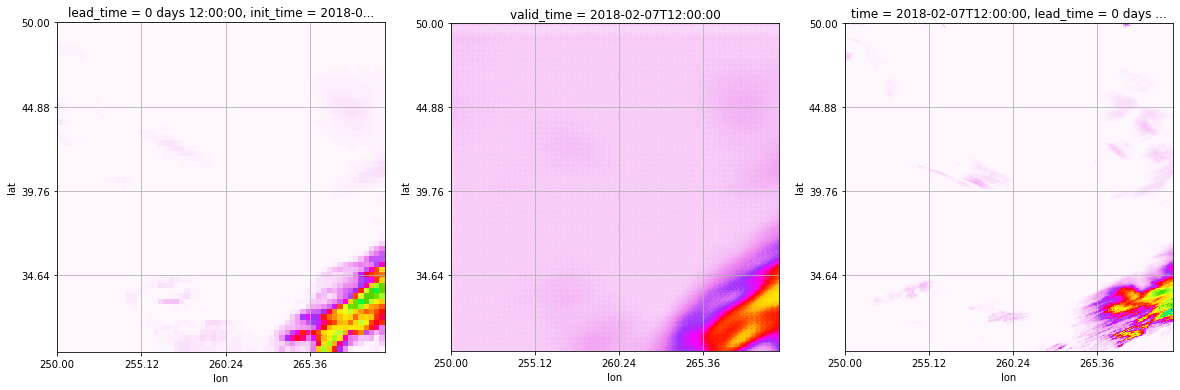

In [26]:
preds = preds_train
ds = ds_train

t = preds.valid_time[20]
lats = slice(50, 30)
lons = slice(250, 270)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
(ds.tigge.sel(variable='tp') * ds.maxs.tp).sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[0], add_colorbar=False)
preds.sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[1], add_colorbar=False)
(ds.mrms * ds.maxs.tp).sel(time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[2], add_colorbar=False)
add_grid(axs)

## Old

In [76]:
class ResidualBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        return out + x

In [77]:
class UpsampleBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv = nn.Conv2d(nf, nf * 4, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.PixelShuffle(2)
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.upsample(out)
        out = self.activation(out)
        return out

In [149]:
class Generator(nn.Module):
    def __init__(self, nres, nf_in, nf, relu_out=True):
        super().__init__()
        self.conv_in = nn.Conv2d(nf_in, nf, kernel_size=9, stride=1, padding=4)
        self.activation_in = nn.LeakyReLU(0.2)
        self.resblocks = nn.Sequential(*[
            ResidualBlock(nf) for i in range(nres)
        ])
        self.upblocks = nn.Sequential(*[
            UpsampleBlock(nf) for i in range(3)
        ])
        self.conv_out = nn.Conv2d(nf, 1, kernel_size=9, stride=1, padding=4)
        self.relu_out = relu_out
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        out = self.conv_in(x)
        out = self.activation_in(out)
        skip = out
        out = self.resblocks(out)
        out = out + skip
        out = self.upblocks(out)
        out = self.conv_out(out)
        if self.relu_out:
            out = nn.functional.relu(out)
        return out

In [150]:
model = Generator(nres=3, nf_in=1, nf=32, relu_out=True).to(device)

In [152]:
model(X.to(device)).shape

torch.Size([32, 1, 128, 128])

In [153]:
criterion = nn.MSELoss()

In [154]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [155]:
from src.models import Trainer

In [156]:
trainer = Trainer(model, optimizer, criterion, dl_train, dl_valid)

In [157]:
trainer.fit(10)

Epoch 10: 100%|██████████| 346/346 [01:11<00:00,  4.85it/s, train_loss=0.00137, valid_loss=0.00371]


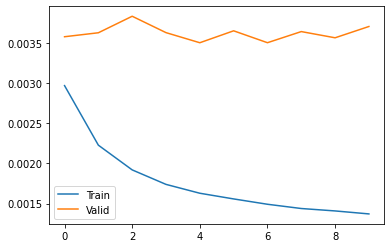

In [158]:
trainer.plot_losses()

In [159]:
from src.evaluate import *

In [ ]:
preds_train = create_valid_predictions(model, ds_train)
preds_valid = create_valid_predictions(model, ds_valid)

  7%|▋         | 6/86 [00:00<00:13,  6.08it/s]

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

In [ ]:
def add_grid(axs):
    for ax in axs:
        ax.set_xticks(np.arange(lons.start, lons.stop, 512/100))
        ax.set_yticks(np.arange(lats.start, lats.stop, -512/100))
        ax.grid(True)
        ax.set_aspect('equal')

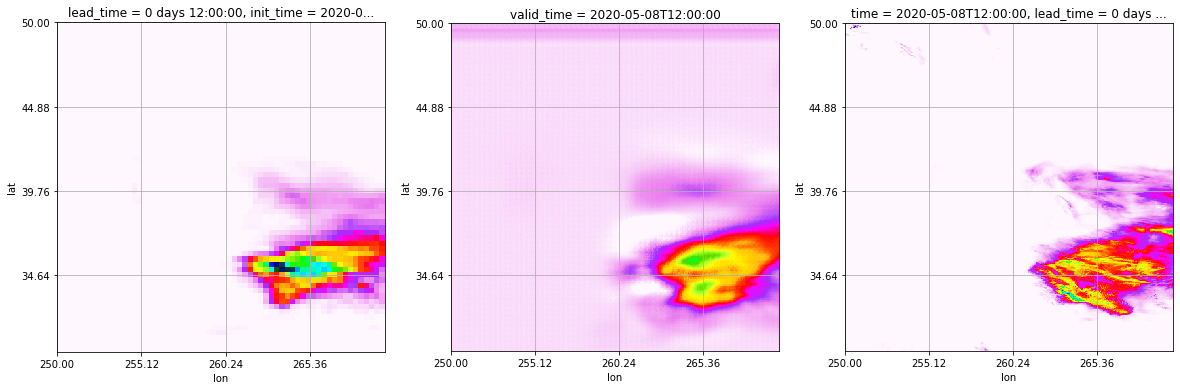

In [168]:
preds = preds_train
ds = ds_train

t = preds.valid_time[1]
lats = slice(50, 30)
lons = slice(250, 270)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
(ds.tigge.sel(variable='tp') * ds.maxs.tp).sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[0], add_colorbar=False)
preds.sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[1], add_colorbar=False)
(ds.mrms * ds.maxs.tp).sel(time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[2], add_colorbar=False)
add_grid(axs)

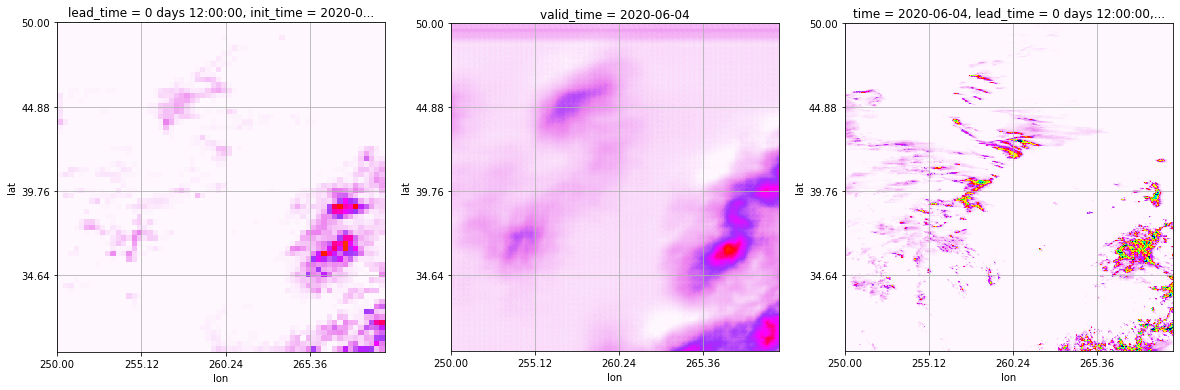

In [169]:
preds = preds_valid
ds = ds_valid

t = preds.valid_time[20]
lats = slice(50, 30)
lons = slice(250, 270)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
(ds.tigge.sel(variable='tp') * ds.maxs.tp).sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[0], add_colorbar=False)
preds.sel(valid_time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[1], add_colorbar=False)
(ds.mrms * ds.maxs.tp).sel(time=t, lat=lats, lon=lons).plot(
    vmin=0, vmax=50, cmap='gist_ncar_r', ax=axs[2], add_colorbar=False)
add_grid(axs)

In [170]:
import os
cwd = os.getcwd()

In [171]:
cwd

'/home/stephan/nwp-downscale/notebooks'

In [172]:
from git import Repo

In [177]:
r = Repo('/home/stephan/nwp-downscale/')

In [182]:
str(r.active_branch.commit)

'e2c46b2d4b950a58e69623f022493aa713f88135'